In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

pl.seed_everything(32)

sys.path.append("/data/danai/scripts/LIVI/")
from src.analysis._utils import compute_umap, select_important_genes_for_factor_IQR
from src.analysis.plotting import plot_gene_loadings_for_factor

Seed set to 32
/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 32


In [2]:
adata = sc.read_h5ad("/data/danai/Data/OneK1K/LogNorm_counts_across_celltypes_DCRM_protein-coding_Azimuth_only-immune-cells_HVG-HEX-10K.h5ad")
adata

AnnData object with n_obs × n_vars = 1172790 × 14212
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent_mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_MITO', 'log1p_total_counts_MITO', 'pct_counts_MITO', 'total_counts_RIBO', 'log1p_total_counts_RIBO', 'pct_counts_RIBO', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC', 'n_genes', 'Norm_factors', 'major_celltype', 'predicted_celltype_l0', 'predicted_celltype_l1', 'predicted_celltype_l2', 'original_celltype', 'new_predicted_celltype_l2', 'new_predicted_celltype_l0', 'new_predicted_celltype_l1'
    var: 'GeneSymbol', 'features', 'MITO', 'RIBO', 'ERCC', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'downregulated_NK', '

In [3]:
gene_anno = pd.read_csv("/data/danai/Data/OneK1K/OneK1K_HVG-HEX-10K_geneIDs_Biomart.txt", sep="\t", index_col=0)
gene_anno.rename(columns={"Gene stable ID":"feature_id", 
                         "Gene name":"gene_name",
                         "Chromosome/scaffold name":"gene_chromosome", 
                         "Gene start (bp)":"gene_start", 
                         "Gene end (bp)":"gene_end"},
                inplace=True)
gene_anno

,gene_start,gene_chromosome,gene_end,gene_name
Gene stable ID,,,,
ENSG00000000419,49551404,20,49575092,DPM1
ENSG00000000457,169818772,1,169863408,SCYL3
ENSG00000000460,169631245,1,169823221,C1orf112
ENSG00000000938,27938575,1,27961788,FGR
ENSG00000000971,196621008,1,196716634,CFH
...,...,...,...,...
ENSG00000273269,47293080,2,47403650,RP11-761B3.1
ENSG00000273274,32930670,1,32962287,ZBTB8B
ENSG00000273294,33987279,5,34124633,RP11-1084J3.4


In [4]:
adata.var.GeneSymbol = adata.var.GeneSymbol.str.strip()
adata.var = adata.var.merge(gene_anno.filter(["gene_chromosome", "gene_start", "gene_end"]), right_index=True, left_index=True)
adata.var

,GeneSymbol,features,MITO,RIBO,ERCC,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,...,downregulated_CD8T,upregulated_B,downregulated_B,upregulated_Mono,downregulated_Mono,upregulated_DC,downregulated_DC,gene_chromosome,gene_start,gene_end
ENSG00000257019,OR13C2,OR13C2,False,False,False,3,0.000002,0.000002,99.999764,3.0,...,False,False,False,False,False,False,False,9,107366924,107367951
ENSG00000166987,MBD6,MBD6,False,False,False,34604,0.027840,0.027459,97.280605,35426.0,...,True,True,True,True,False,False,True,12,57914493,57923931
ENSG00000170624,SGCD,SGCD,False,False,False,1844,0.001487,0.001486,99.855087,1892.0,...,False,True,True,True,True,False,True,5,155297354,156194799
ENSG00000140519,RHCG,RHCG,False,False,False,2,0.000002,0.000002,99.999843,2.0,...,False,False,False,False,False,False,False,15,89998680,90039844
ENSG00000117115,PADI2,PADI2,False,False,False,2728,0.002279,0.002276,99.785617,2900.0,...,True,True,True,True,False,True,True,1,17393256,17445948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000185811,IKZF1,IKZF1,False,False,False,338926,0.332737,0.287235,73.365114,423404.0,...,True,True,True,True,True,False,True,7,50343720,50472799
ENSG00000234465,PINLYP,PINLYP,False,False,False,3098,0.002490,0.002487,99.756540,3168.0,...,False,False,False,False,False,False,False,19,44080952,44088116
ENSG00000170615,SLC26A5,SLC26A5,False,False,False,685,0.000540,0.000540,99.946168,687.0,...,False,False,False,False,False,False,False,7,102993177,103086624
ENSG00000151778,SERP2,SERP2,False,False,False,2513,0.002013,0.002011,99.802513,2561.0,...,True,True,True,True,True,False,True,13,44947801,44971850


In [5]:
results_dir = "/data/danai/Data/OneK1K/LIVI2_testing_results/"
model = "2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder_best"
model_results_dir = os.path.join(results_dir, model)
os.path.isdir(model_results_dir)

True

In [6]:
D = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_U_embedding.tsv"),
    sep="\t", index_col=0
)
D.columns = D.columns.str.replace("U_", "D_")
D.head()

,D_Factor1,D_Factor2,D_Factor3,D_Factor4,D_Factor5,D_Factor6,D_Factor7,D_Factor8,D_Factor9,D_Factor10,...,D_Factor691,D_Factor692,D_Factor693,D_Factor694,D_Factor695,D_Factor696,D_Factor697,D_Factor698,D_Factor699,D_Factor700
individual,,,,,,,,,,,,,,,,,,,,,
691_692,-1.042473,-3.014132,1.014801,1.139763,-0.087979,-0.651705,0.490216,-0.437837,-0.698968,-0.075018,...,-1.559727,-2.399024,-0.448335,-0.562907,1.627759,0.417358,-0.134628,0.011702,-0.679321,0.457391
693_694,0.204075,-1.975144,-0.909941,-3.882647,-2.031409,-1.043576,-0.600040,0.700274,-1.798226,1.284830,...,-4.333742,-0.440545,3.113877,-1.716786,-1.533546,0.933507,1.020350,0.339764,-1.053410,0.119764
688_689,-0.265995,-0.624907,-0.622831,-2.176815,0.853737,-0.117719,0.055314,0.302469,0.608836,-1.786304,...,-0.670751,-1.207303,8.913930,-0.353388,-0.325745,-1.125641,0.403694,-0.928585,0.525144,-0.484701
683_684,0.416159,-2.862958,-0.515983,1.572177,0.868042,-0.119366,-0.109651,0.556453,1.886532,-1.681124,...,-2.243293,-1.778274,0.387456,0.630929,-0.590417,0.165828,-2.937147,0.222008,-0.201923,0.057328
684_685,-1.244226,-4.169203,-0.287462,-0.519455,3.750650,-1.336222,0.230874,-0.624908,1.064494,0.636243,...,0.699778,-3.021685,-0.273128,-0.655736,-0.635290,0.228497,1.079147,-1.051518,0.797644,0.003049


In [7]:
DxC_decoder = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_GxC_decoder.tsv"),
    sep="\t", index_col=0
)
DxC_decoder.columns = DxC_decoder.columns.str.replace("GxC", "DxC")
DxC_decoder.head()

,DxC_Factor1,DxC_Factor2,DxC_Factor3,DxC_Factor4,DxC_Factor5,DxC_Factor6,DxC_Factor7,DxC_Factor8,DxC_Factor9,DxC_Factor10,...,DxC_Factor691,DxC_Factor692,DxC_Factor693,DxC_Factor694,DxC_Factor695,DxC_Factor696,DxC_Factor697,DxC_Factor698,DxC_Factor699,DxC_Factor700
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000257019,0.000003,-0.000156,0.000261,-0.000105,0.000109,-0.000148,0.000145,0.000002,0.000106,-0.000083,...,-0.000125,-0.000088,0.000062,-0.000037,-0.000043,-0.000013,-0.000199,-0.000141,0.000042,0.000049
ENSG00000166987,-0.000101,-0.000302,0.000002,-0.000025,0.000096,-0.000122,0.000290,-0.000218,-0.000033,0.000128,...,-0.000093,-0.000059,-0.000712,0.000007,-0.000217,0.000056,0.000027,0.000117,-0.000141,0.000014
ENSG00000170624,-0.000007,-0.000096,-0.000228,0.000753,-0.000033,-0.000042,-0.000032,0.001457,0.000291,-0.000079,...,-0.000690,0.000181,-0.004836,0.000014,-0.000040,0.000021,0.000080,0.000070,-0.000669,-0.000014
ENSG00000140519,0.000013,-0.000071,0.000062,-0.000007,-0.000070,0.000082,-0.000036,0.000126,-0.000059,-0.000021,...,0.000164,0.000251,-0.000099,0.000035,-0.000080,-0.000019,-0.000139,0.000042,-0.000011,-0.000129
ENSG00000117115,-0.000463,-0.000236,0.000113,-0.000527,0.000036,0.000147,-0.000130,-0.000716,-0.000064,0.000002,...,0.000046,0.000210,0.000123,-0.000185,-0.000235,0.000060,-0.000145,0.000712,-0.000128,-0.000025


In [8]:
GxC_effects =  pd.read_csv(
    os.path.join(model_results_dir, f"{model}_LMM_results_BH-0.05_Ucontext.tsv"),
    sep="\t")
GxC_effects.Factor = GxC_effects.Factor.str.replace("U_", "D_")
GxC_effects

,Factor,SNP_id,effect_size,effect_size_se,p_value,assessed_allele,corrected_pvalue
0,D_Factor1,14:81884515,0.128089,0.029964,1.747683e-05,G,3.124271e-02
1,D_Factor5,19:58963530,0.585091,0.071890,1.218412e-16,G,8.928493e-13
2,D_Factor11,6:161111700,1.012741,0.201583,4.265749e-07,C,1.083497e-03
3,D_Factor12,3:39555580,0.505091,0.055674,1.831975e-20,A,1.759641e-16
4,D_Factor14,2:232579379,-0.201663,0.025578,1.112895e-15,G,7.537058e-12
...,...,...,...,...,...,...,...
3989,D_Factor696,6:35402805,2.013616,0.270934,4.697587e-14,C,2.723306e-10
3990,D_Factor698,22:37918472,0.315602,0.064524,8.591598e-07,T,2.062331e-03
3991,D_Factor698,22:38175477,0.298677,0.057110,1.387957e-07,T,3.829152e-04
3992,D_Factor700,2:102957291,-0.758697,0.154228,7.418975e-07,A,1.806789e-03


In [9]:
GxC_effects.SNP_id.nunique()

941

In [10]:
GxC_effects.Factor.nunique()

323

#### Number of D factors associated with each SNP

Text(9.319444444444445, 0.5, 'Count')

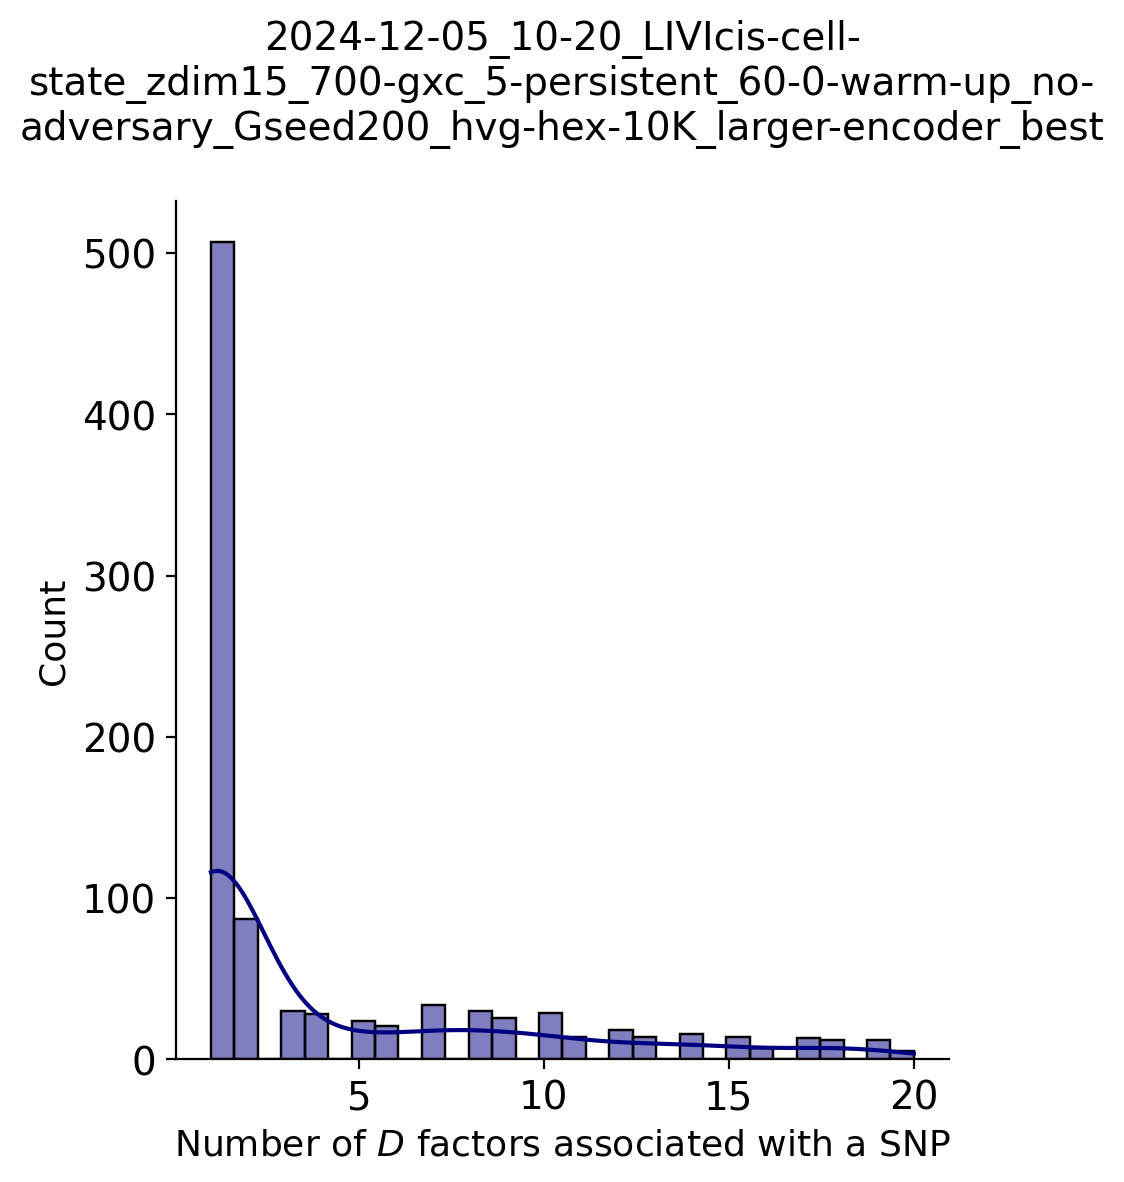

In [11]:
sns.displot(GxC_effects.groupby("SNP_id").apply(lambda x: x.Factor.nunique(), include_groups=False), kde=True, 
            color="navy", bins=30) # bins="fd"
plt.title("\n".join(textwrap.wrap(model, 50)) + "\n")
plt.xlabel("Number of $D$ factors associated with a SNP", fontsize=13)
plt.ylabel("Count", fontsize=13)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


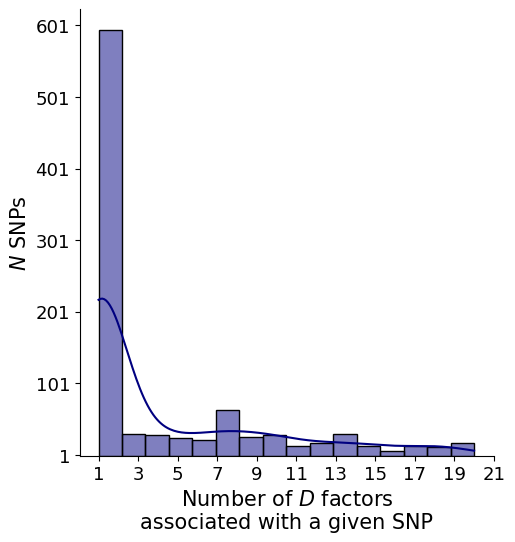

In [13]:
sns.displot(GxC_effects.groupby("SNP_id").apply(lambda x: x.Factor.nunique(), include_groups=False), kde=True, color="navy", bins="fd")
# plt.title("\n".join(wrap(model, 50)) + "\n")
plt.xticks(ticks=np.arange(1,22,2), labels=np.arange(1,22,2), fontdict={"fontsize":13})
plt.xlabel(textwrap.fill("Number of $D$ factors associated with a given SNP", 30), fontsize=15)
plt.ylabel("$N$ SNPs", fontsize=15)
plt.yticks(ticks=np.arange(1,701,100), labels=np.arange(1,701,100), fontdict={"fontsize":13})
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_N_D-factors_associated-with-a-given-SNP.png"),
            transparent=True, bbox_inches="tight", dpi=200)
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_N_D-factors_associated-with-a-given-SNP.eps"),
            transparent=True, bbox_inches="tight", dpi=200)
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_N_D-factors_associated-with-a-given-SNP.pdf"),
            transparent=True, bbox_inches="tight", dpi=200)

#### Number of SNPs associated with a given D factor

Text(9.319444444444445, 0.5, 'Count')

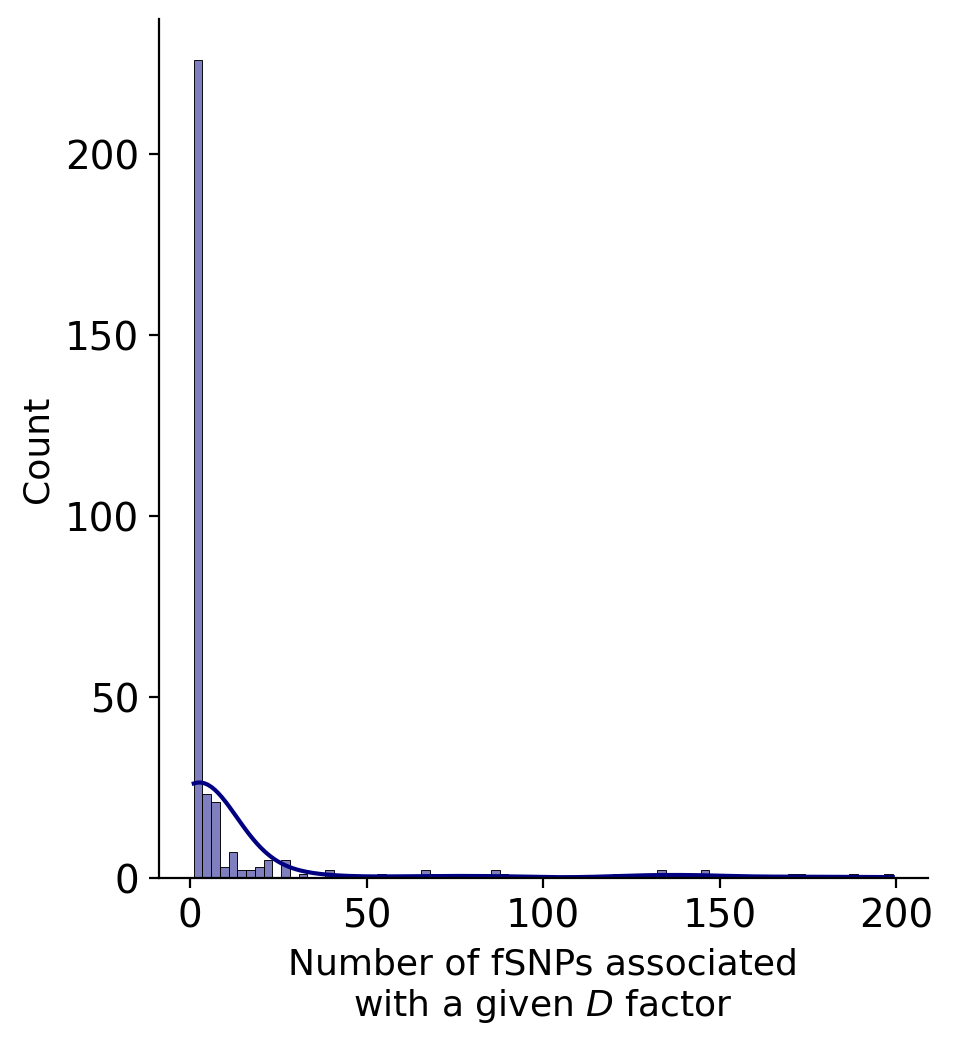

In [183]:
sns.displot(GxC_effects.groupby("Factor").apply(lambda x: x.SNP_id.nunique(), include_groups=False),
            kde=True, color="navy", bins=80)
plt.xlabel(textwrap.fill("Number of fSNPs associated with a given $D$ factor", 30), fontsize=13)
plt.ylabel("Count", fontsize=13)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


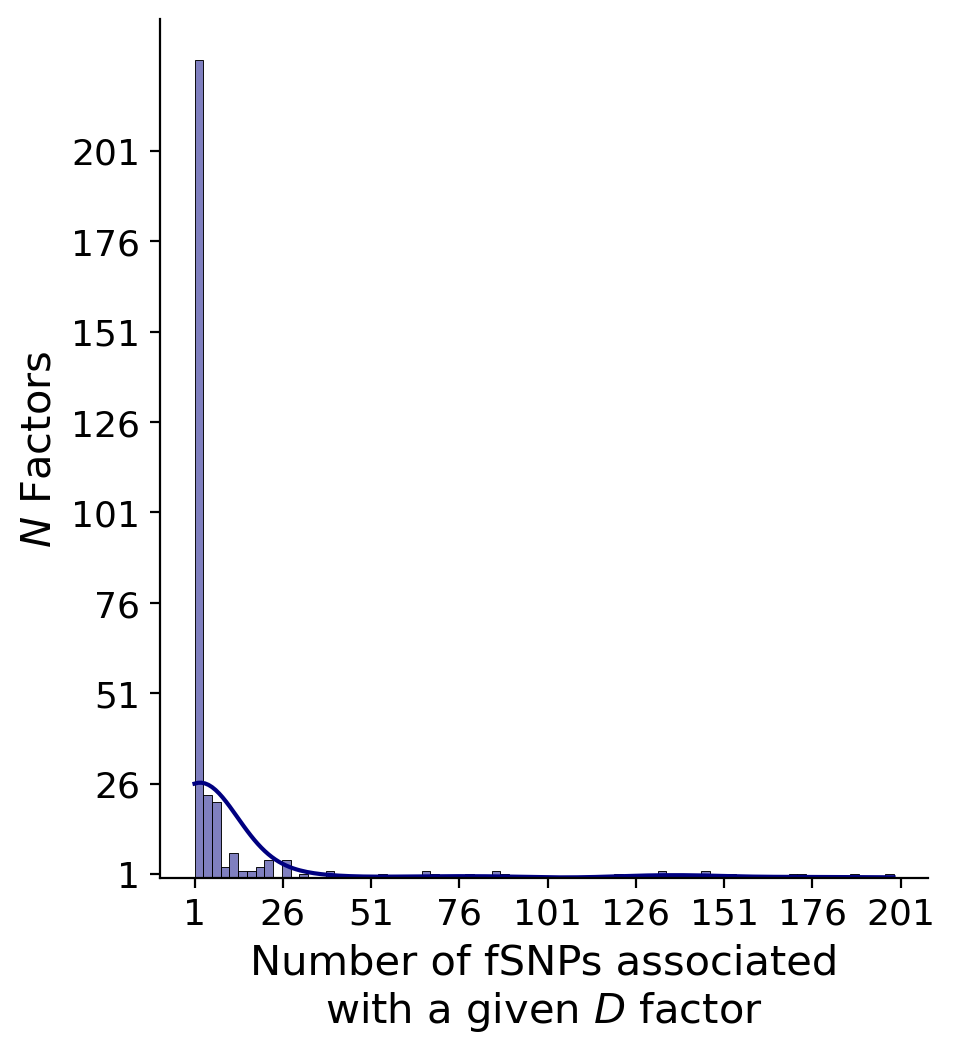

In [184]:
sns.displot(GxC_effects.groupby("Factor").apply(lambda x: x.SNP_id.nunique(), include_groups=False), kde=True,
            color="navy", bins=80) #  bins="fd"
plt.xticks(ticks=np.arange(1,226,25), labels=np.arange(1,226,25), fontdict={"fontsize":13})
plt.xlabel(textwrap.fill("Number of fSNPs associated with a given $D$ factor", 30), fontsize=15)
plt.ylabel("$N$ Factors", fontsize=15)
plt.yticks(ticks=np.arange(1,226,25), labels=np.arange(1,226,25), fontdict={"fontsize":13})
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_N_fSNPs_associated-with-a-given-D-factor.png"),
            transparent=True, bbox_inches="tight", dpi=200)
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_N_fSNPs_associated-with-a-given-D-factor.eps"),
            transparent=True, bbox_inches="tight", dpi=200)
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_N_fSNPs_associated-with-a-given-D-factor.pdf"),
            transparent=True, bbox_inches="tight", dpi=200)


#### DxC_decoder sparsity

In [16]:
DxC_decoder =  pd.read_csv(
    os.path.join(model_results_dir, f"{model}_GxC_decoder.tsv"),
    sep="\t", index_col=0
)

DxC_decoder 

,GxC_Factor1,GxC_Factor2,GxC_Factor3,GxC_Factor4,GxC_Factor5,GxC_Factor6,GxC_Factor7,GxC_Factor8,GxC_Factor9,GxC_Factor10,...,GxC_Factor691,GxC_Factor692,GxC_Factor693,GxC_Factor694,GxC_Factor695,GxC_Factor696,GxC_Factor697,GxC_Factor698,GxC_Factor699,GxC_Factor700
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000257019,0.000003,-0.000156,0.000261,-0.000105,0.000109,-0.000148,0.000145,0.000002,0.000106,-0.000083,...,-0.000125,-0.000088,0.000062,-0.000037,-0.000043,-0.000013,-0.000199,-0.000141,0.000042,0.000049
ENSG00000166987,-0.000101,-0.000302,0.000002,-0.000025,0.000096,-0.000122,0.000290,-0.000218,-0.000033,0.000128,...,-0.000093,-0.000059,-0.000712,0.000007,-0.000217,0.000056,0.000027,0.000117,-0.000141,0.000014
ENSG00000170624,-0.000007,-0.000096,-0.000228,0.000753,-0.000033,-0.000042,-0.000032,0.001457,0.000291,-0.000079,...,-0.000690,0.000181,-0.004836,0.000014,-0.000040,0.000021,0.000080,0.000070,-0.000669,-0.000014
ENSG00000140519,0.000013,-0.000071,0.000062,-0.000007,-0.000070,0.000082,-0.000036,0.000126,-0.000059,-0.000021,...,0.000164,0.000251,-0.000099,0.000035,-0.000080,-0.000019,-0.000139,0.000042,-0.000011,-0.000129
ENSG00000117115,-0.000463,-0.000236,0.000113,-0.000527,0.000036,0.000147,-0.000130,-0.000716,-0.000064,0.000002,...,0.000046,0.000210,0.000123,-0.000185,-0.000235,0.000060,-0.000145,0.000712,-0.000128,-0.000025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000185811,-0.000110,0.002336,-0.000056,0.000462,-0.000005,0.000142,0.000071,-0.009100,0.000140,0.000063,...,-0.000346,-0.000582,-0.000197,0.000033,0.000525,0.000056,0.000059,0.000055,-0.000600,-0.000257
ENSG00000234465,-0.000032,0.000183,-0.000025,0.000108,0.000133,0.000220,-0.000154,0.000586,-0.000165,-0.000111,...,-0.000250,0.000015,0.000105,0.000068,0.000117,-0.000131,0.000086,-0.000222,0.000342,-0.000027
ENSG00000170615,0.000065,0.000413,0.000010,0.000060,-0.000052,-0.000140,0.000233,-0.000027,-0.000191,-0.000071,...,0.000147,-0.000052,0.000095,0.000084,-0.000187,0.000040,-0.000055,-0.000071,0.000049,-0.000059


Text(0.5, 1.0, 'Mean gene loadings for each DxC factor')

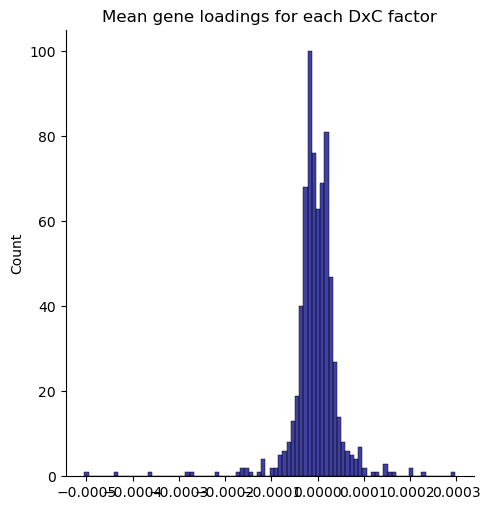

In [18]:
sns.displot(DxC_decoder.mean(axis=0), color="navy")
plt.title("Mean gene loadings for each DxC factor")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


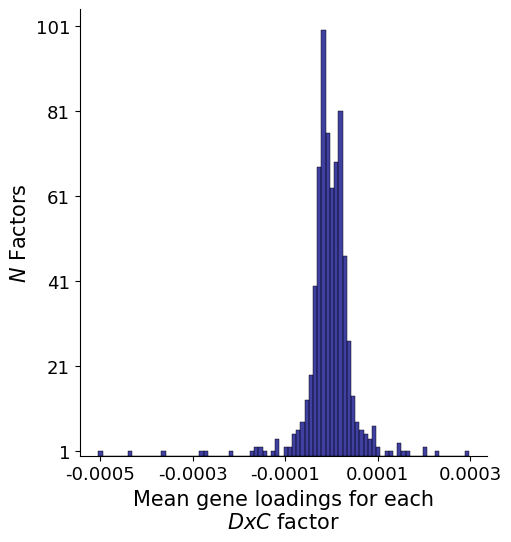

In [32]:
sns.displot(DxC_decoder.mean(axis=0), color="navy")
plt.xticks(np.round(np.arange(-5e-4, 4e-4, 2e-4), 4), np.round(np.arange(-5e-4, 4e-4, 2e-4), 4), fontdict={"fontsize":13})
plt.xlabel(textwrap.fill("Mean gene loadings for each $DxC$ factor", 30), fontsize=15)
plt.yticks(np.arange(1, 121, 20), np.arange(1, 121, 20), fontdict={"fontsize":13})
plt.ylabel("$N$ Factors", fontsize=15)
plt.savefig(os.path.join(model_results_dir, "Figures", "Mean gene loadings for each DxC factor".replace(" ", "-")+".png"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Mean gene loadings for each DxC factor".replace(" ", "-")+".eps"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Mean gene loadings for each DxC factor".replace(" ", "-")+".pdf"), 
            transparent=True, dpi=200, bbox_inches="tight")

In [20]:
DxC_decoder_sign = DxC_decoder.filter(GxC_effects.Factor.str.replace("D", "DxC").unique())
DxC_decoder_sign.shape

(14212, 323)

Text(0.5, 1.0, 'Mean gene loadings for each significant DxC factor')

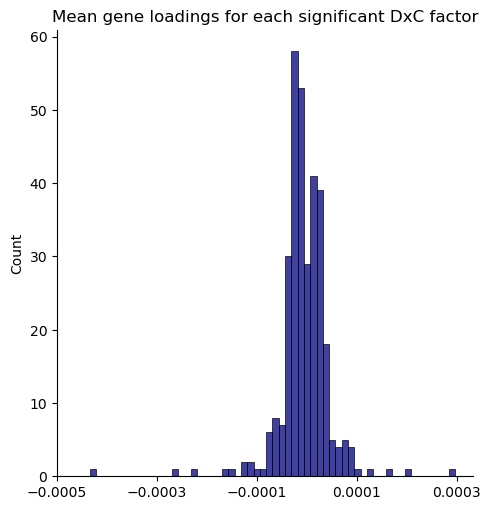

In [22]:
sns.displot(DxC_decoder_sign.mean(axis=0), color="navy")
plt.xticks(np.arange(-5e-4, 4e-4, 2e-4))
plt.title("Mean gene loadings for each significant DxC factor")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


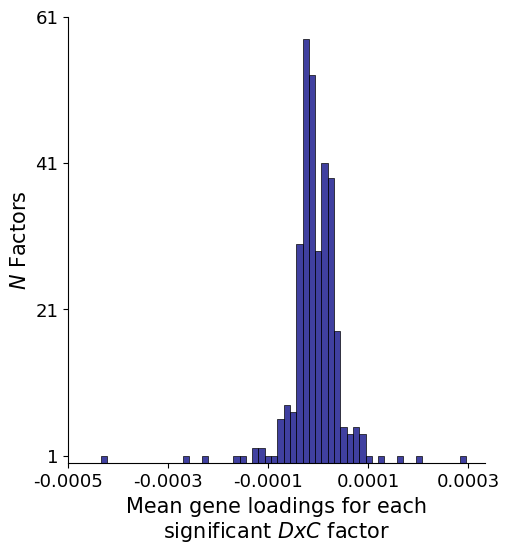

In [31]:
sns.displot(DxC_decoder_sign.mean(axis=0), color="navy")
plt.xticks(np.round(np.arange(-5e-4, 4e-4, 2e-4), 4), np.round(np.arange(-5e-4, 4e-4, 2e-4), 4), fontdict={"fontsize":13})
plt.xlabel(textwrap.fill("Mean gene loadings for each significant $DxC$ factor", 30), fontsize=15)
plt.yticks(np.arange(1, 81, 20), np.arange(1, 81, 20), fontdict={"fontsize":13})
plt.ylabel("$N$ Factors", fontsize=15)
plt.savefig(os.path.join(model_results_dir, "Figures", "Mean gene loadings for each significant DxC factor".replace(" ", "-")+".png"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Mean gene loadings for each significant DxC factor".replace(" ", "-")+".eps"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Mean gene loadings for each significant DxC factor".replace(" ", "-")+".pdf"), 
            transparent=True, dpi=200, bbox_inches="tight")

In [21]:
mean_loadings = DxC_decoder.mean(axis=0).rename("Mean_loadings").reset_index().rename(columns={"index":"Factor"})
mean_loadings.head()

,Factor,Mean_loadings
0,DxC_Factor1,2.861740e-05
1,DxC_Factor2,2.704518e-05
2,DxC_Factor3,-7.032566e-07
3,DxC_Factor4,1.441811e-04
4,DxC_Factor5,-2.420637e-05


In [23]:
mean_loadings = mean_loadings.assign(
    has_fQTL = mean_loadings.apply(lambda x: x.Factor in GxC_effects.Factor.str.replace("D", "DxC").tolist(), axis=1)
)
mean_loadings.head()

,Factor,Mean_loadings,has_fQTL
0,DxC_Factor1,2.861740e-05,True
1,DxC_Factor2,2.704518e-05,False
2,DxC_Factor3,-7.032566e-07,False
3,DxC_Factor4,1.441811e-04,False
4,DxC_Factor5,-2.420637e-05,True


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


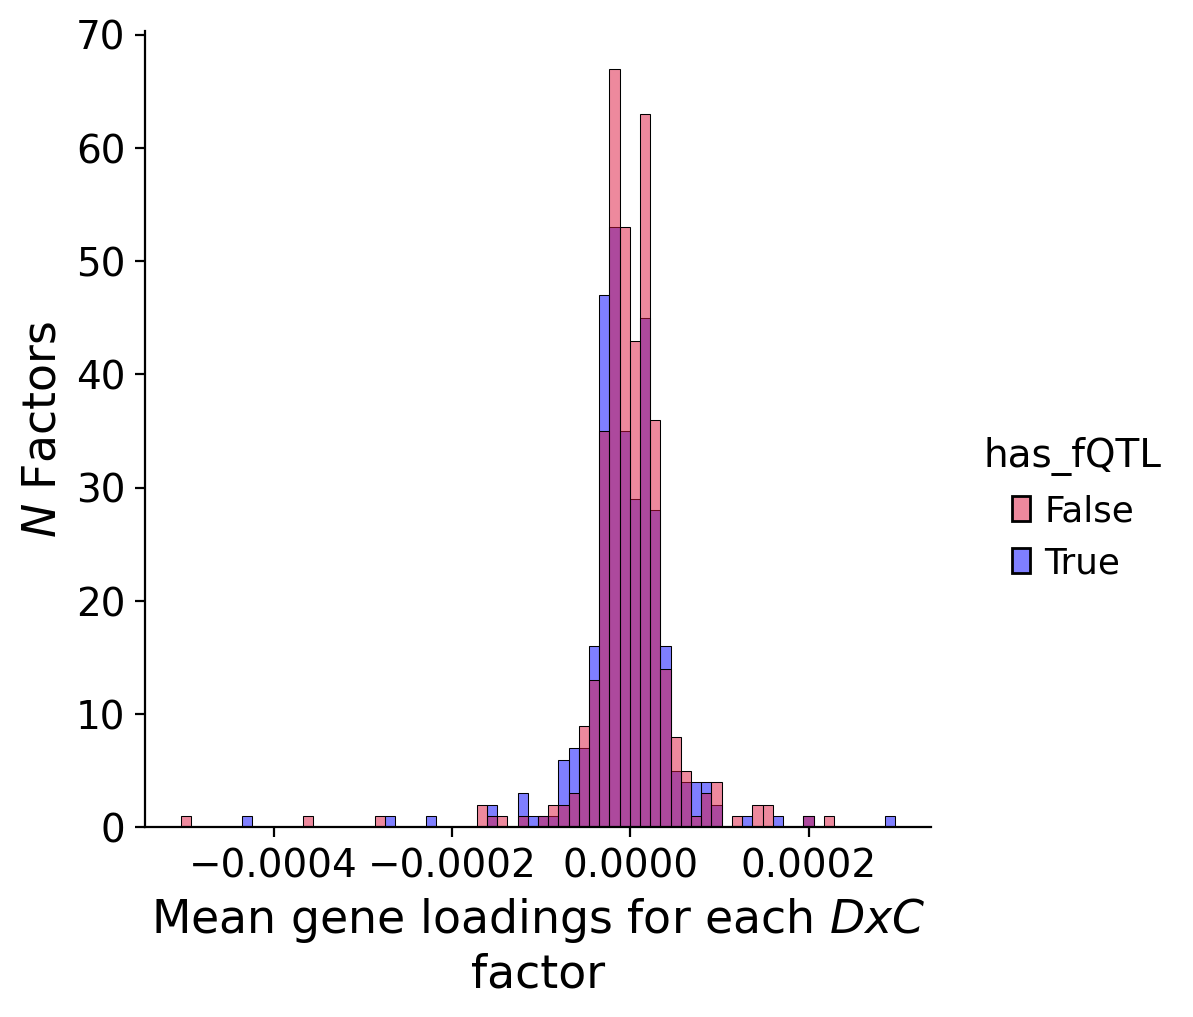

In [165]:
sns.displot(data=mean_loadings, x="Mean_loadings", hue="has_fQTL", palette=["crimson", "blue"], bins=70, alpha=0.5)
plt.xlabel(textwrap.fill("Mean gene loadings for each $DxC$ factor", 35), fontsize=16.5)
plt.ylabel("$N$ Factors", fontsize=16.5)
plt.savefig(os.path.join(model_results_dir, "Figures", "Mean-gene-loadings-for-each-DxC-factor_has-fQTL.png"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Mean-gene-loadings-for-each-DxC-factor_has-fQTL.eps"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Mean-gene-loadings-for-each-DxC-factor_has-fQTL.pdf"), 
            transparent=True, dpi=200, bbox_inches="tight")

Text(0.5, 1.0, 'Number of genes with non-zero loadings for each significant DxC factor')

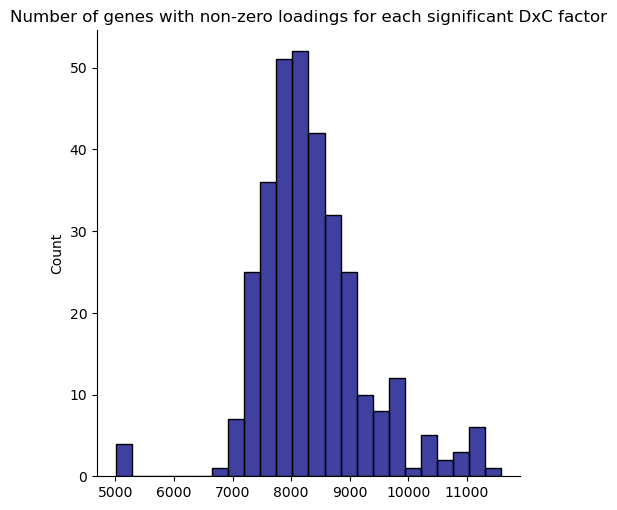

In [24]:
# Assuming non-zero loadinds means not between -1e-4 and 1e-4
sns.displot(DxC_decoder_sign.apply(lambda x: (x < - 0.0001) | (x > 0.0001), axis=0).sum(axis=0), color="navy")
plt.title("Number of genes with non-zero loadings for each significant DxC factor")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


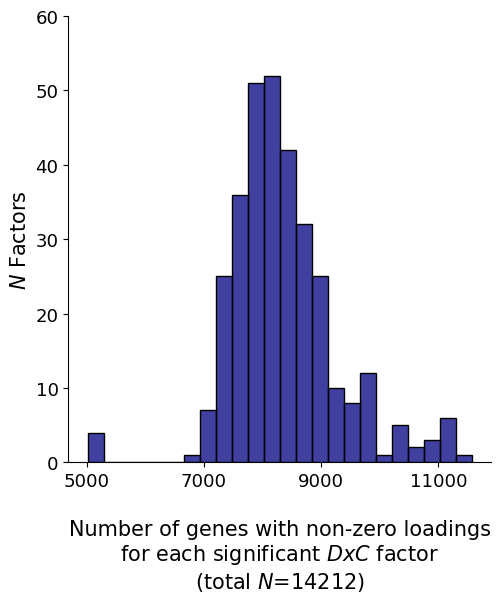

In [30]:
# Assuming non-zero loadinds means not between -1e-4 and 1e-4
sns.displot(DxC_decoder_sign.apply(lambda x: (x < - 0.0001) | (x > 0.0001), axis=0).sum(axis=0), color="navy")
plt.xlabel("\n"+textwrap.fill("Number of genes with non-zero loadings for each significant $DxC$ factor", 40)+f"\n(total $N$={DxC_decoder.shape[0]})", fontsize=15)
plt.xticks(np.arange(5000, 13000, 2000), np.arange(5000, 13000, 2000), fontdict={"fontsize":13})
plt.ylabel("$N$ Factors", fontsize=15)
plt.yticks(np.arange(0, 70, 10), np.arange(0, 70, 10), fontdict={"fontsize":13})
plt.savefig(os.path.join(model_results_dir, "Figures", "Number of genes with non-zero loadings for each significant DxC factor".replace(" ", "-")+".png"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Number of genes with non-zero loadings for each significant DxC factor".replace(" ", "-")+".eps"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Number of genes with non-zero loadings for each significant DxC factor".replace(" ", "-")+".pdf"), 
            transparent=True, dpi=200, bbox_inches="tight")

Text(0.5, 1.0, 'Number of genes with non-zero loadings for each DxC factor')

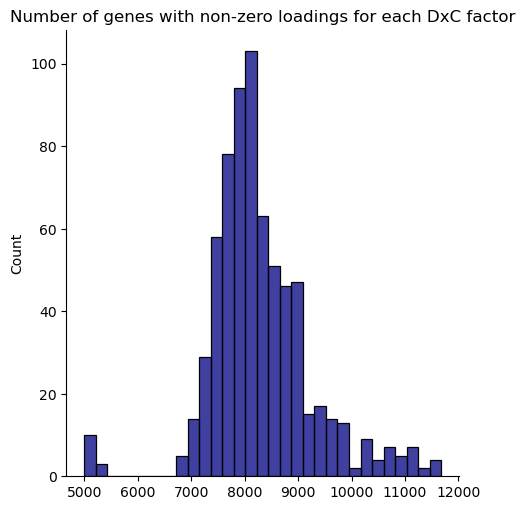

In [26]:
sns.displot(DxC_decoder.apply(lambda x: (x < - 0.0001) | (x > 0.0001), axis=0).sum(axis=0), color="navy")
plt.title("Number of genes with non-zero loadings for each DxC factor")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


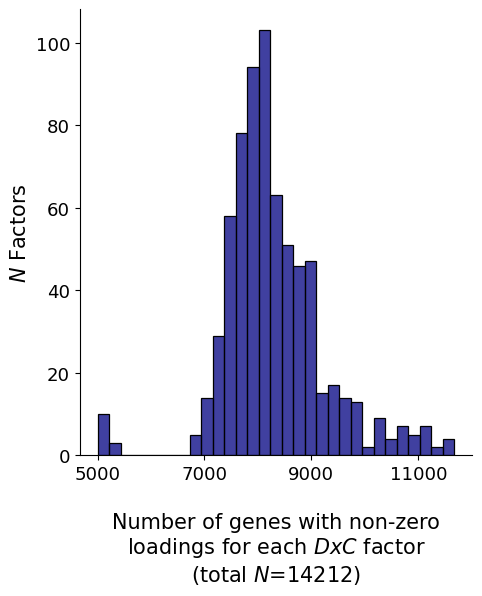

In [29]:
sns.displot(DxC_decoder.apply(lambda x: (x < - 0.0001) | (x > 0.0001), axis=0).sum(axis=0), color="navy")
plt.xlabel("\n"+textwrap.fill("Number of genes with non-zero loadings for each $DxC$ factor", 30)+f"\n(total $N$={DxC_decoder.shape[0]})", fontsize=15)
plt.xticks(np.arange(5000, 13000, 2000), np.arange(5000, 13000, 2000), fontdict={"fontsize":13})
plt.ylabel("$N$ Factors", fontsize=15)
plt.yticks(np.arange(0, 120, 20), np.arange(0, 120, 20), fontdict={"fontsize":13})
plt.savefig(os.path.join(model_results_dir, "Figures", "Number of genes with non-zero loadings for each DxC factor".replace(" ", "-")+".png"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Number of genes with non-zero loadings for each DxC factor".replace(" ", "-")+".eps"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Number of genes with non-zero loadings for each DxC factor".replace(" ", "-")+".pdf"), 
            transparent=True, dpi=200, bbox_inches="tight")

Text(0.5, 1.0, 'Max gene loadings for each DxC factor')

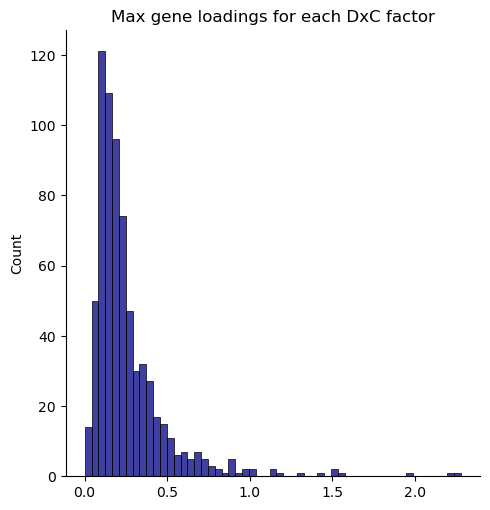

In [34]:
sns.displot(np.absolute(DxC_decoder.to_numpy()).max(axis=0), color="navy")
plt.title("Max gene loadings for each DxC factor")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


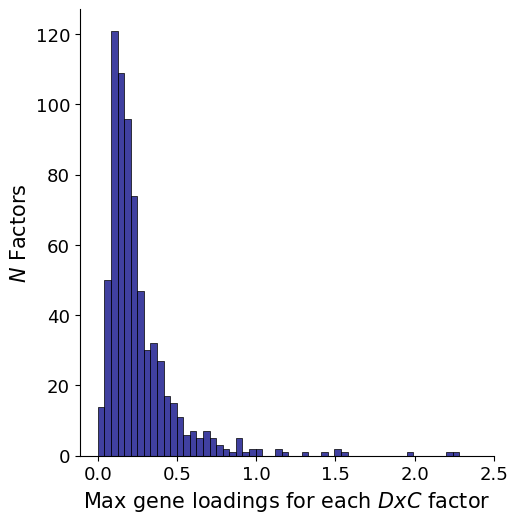

In [35]:
sns.displot(np.absolute(DxC_decoder.to_numpy()).max(axis=0), color="navy")
plt.xlabel(textwrap.fill("Max gene loadings for each $DxC$ factor", 40), fontsize=15)
plt.xticks(np.arange(0.0, 3.0, 0.5), np.arange(0.0, 3.0, 0.5), fontdict={"fontsize":13})
plt.ylabel("$N$ Factors", fontsize=15)
plt.yticks(np.arange(0, 140, 20), np.arange(0, 140, 20), fontdict={"fontsize":13})
plt.savefig(os.path.join(model_results_dir, "Figures", "Max gene loadings for each DxC factor".replace(" ", "-")+".png"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Max gene loadings for each DxC factor".replace(" ", "-")+".eps"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Max gene loadings for each DxC factor".replace(" ", "-")+".pdf"), 
            transparent=True, dpi=200, bbox_inches="tight")

Text(0.5, 1.0, 'Max gene loadings for each significant DxC factor')

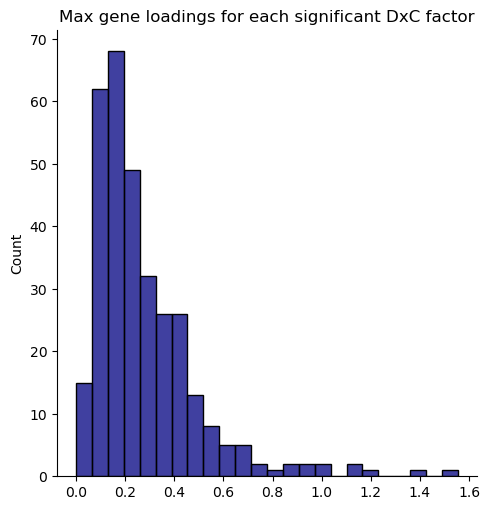

In [37]:
sns.displot(np.absolute(DxC_decoder_sign.to_numpy()).max(axis=0), color="navy")
plt.title("Max gene loadings for each significant DxC factor")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


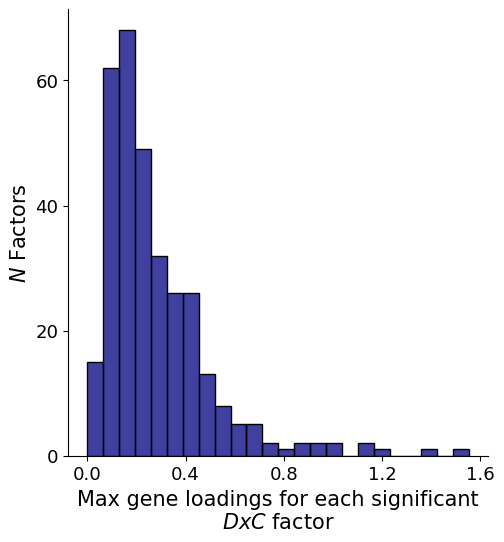

In [38]:
sns.displot(np.absolute(DxC_decoder_sign.to_numpy()).max(axis=0), color="navy")
plt.xlabel(textwrap.fill("Max gene loadings for each significant $DxC$ factor", 40), fontsize=15)
plt.xticks(np.round(np.arange(0.0, 1.8, 0.4), 1), np.round(np.arange(0.0, 1.8, 0.4), 1), fontdict={"fontsize":13})
plt.ylabel("$N$ Factors", fontsize=15)
plt.yticks(np.arange(0, 80, 20), np.arange(0, 80, 20), fontdict={"fontsize":13})
plt.savefig(os.path.join(model_results_dir, "Figures", "Max gene loadings for each significant DxC factor".replace(" ", "-")+".png"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Max gene loadings for each significant DxC factor".replace(" ", "-")+".eps"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Max gene loadings for each significant DxC factor".replace(" ", "-")+".pdf"), 
            transparent=True, dpi=200, bbox_inches="tight")

In [39]:
GxC_effects.groupby("SNP_id", observed=True).apply(lambda x: x.Factor.nunique()).median()

/tmp/ipykernel_1110489/3300783916.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  GxC_effects.groupby("SNP_id", observed=True).apply(lambda x: x.Factor.nunique()).median()


1.0

In [25]:
max_loadings = DxC_decoder.abs().max(axis=0).rename("Max_loadings").reset_index().rename(columns={"index":"Factor"})
max_loadings = max_loadings.assign(has_fQTL = max_loadings.apply(
    lambda x: x.Factor in GxC_effects.Factor.str.replace("D", "DxC").tolist(), axis=1)
                                    )
max_loadings

,Factor,Max_loadings,has_fQTL
0,DxC_Factor1,0.110348,True
1,DxC_Factor2,0.216600,False
2,DxC_Factor3,0.000365,False
3,DxC_Factor4,0.230327,False
4,DxC_Factor5,0.341691,True
...,...,...,...
695,DxC_Factor696,0.588433,True
696,DxC_Factor697,0.237591,False
697,DxC_Factor698,0.320259,True
698,DxC_Factor699,0.288963,False


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


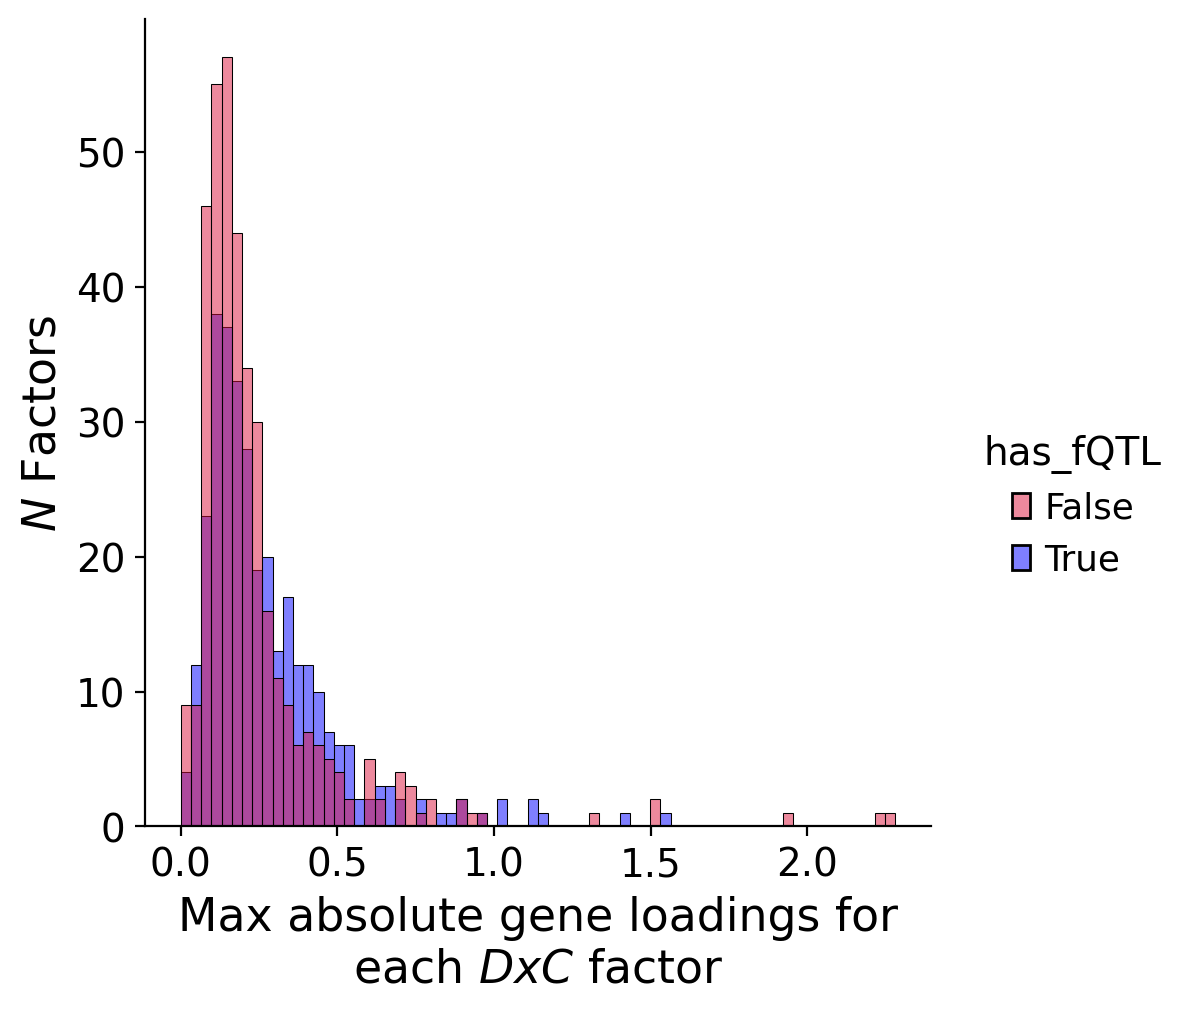

In [169]:
sns.displot(data=max_loadings, x="Max_loadings", hue="has_fQTL", palette=["crimson", "blue"], bins=70, alpha=0.5)
plt.xlabel(textwrap.fill("Max absolute gene loadings for each $DxC$ factor", 33), fontsize=16.5)
plt.ylabel("$N$ Factors", fontsize=16.5)
plt.savefig(os.path.join(model_results_dir, "Figures", "Max-gene-loadings-for-each-DxC-factor_has-fQTL.png"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Max-gene-loadings-for-each-DxC-factor_has-fQTL.eps"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Max-gene-loadings-for-each-DxC-factor_has-fQTL.pdf"), 
            transparent=True, dpi=200, bbox_inches="tight")

#### N TopGenes for each DxC factor

##### One IQR threshold

In [14]:
factors = []
topgenes = []

for fa in DxC_decoder.columns:
    tgenes = select_important_genes_for_factor_IQR(
        genes_factors_loadings=DxC_decoder.to_numpy(),
        factor_idx=int(fa.replace("DxC_Factor", ""))-1,
        gene_names=adata.var.loc[DxC_decoder.index].GeneSymbol,
        direction="both",
        threshold = 100,
        plot = False,
    )
    # thres = 100
    # if len(tgenes) == 0:
    #     tgenes = select_important_genes_for_factor_IQR(
    #         genes_factors_loadings=DxC_decoder.to_numpy(),
    #         factor_idx=int(fa.replace("GxC_Factor", ""))-1,
    #         gene_names=adata.var.loc[DxC_decoder.index].GeneSymbol,
    #         direction="both",
    #         threshold = 10,
    #         plot = False,
    #     )
    #     thres = 10
    # if len(tgenes) == 0:
    #     tgenes = select_important_genes_for_factor_IQR(
    #         genes_factors_loadings=DxC_decoder.to_numpy(),
    #         factor_idx=int(fa.replace("GxC_Factor", ""))-1,
    #         gene_names=adata.var.loc[DxC_decoder.index].GeneSymbol,
    #         direction="both",
    #         threshold = 1.5,
    #         plot = False,
    #     )
    #     thres = 1.5
    topgenes.append(tgenes)
    factors.append(fa)
    # threshold.append(thres)

In [15]:
factors_topgenes = pd.DataFrame({"Factor":factors, "TopGenes":topgenes})
factors_topgenes = factors_topgenes.assign(N_genes = factors_topgenes.apply(lambda x: len(x.TopGenes), axis=1))
factors_topgenes = factors_topgenes.assign(TopGenes = ["; ".join(tg) for tg in factors_topgenes.TopGenes])
factors_topgenes.head()

,Factor,TopGenes,N_genes
0,DxC_Factor1,FTL; CCL4; RPS16,3
1,DxC_Factor2,A1BG; SOX4; ITM2A; CD8B; CD8A; TXNIP; CLEC11A;...,10
2,DxC_Factor3,,0
3,DxC_Factor4,VMP1; CITED2; TSC22D3; ARRDC3; TNFAIP3; CD69; ...,13
4,DxC_Factor5,RPS5; RPS25,2


In [16]:
factors_topgenes.N_genes.median()

2.0

In [120]:
factors_topgenes.to_csv(
    os.path.join(model_results_dir, "All_DxC-Factors_TopGenes_only-100-IQR.tsv"), 
    sep="\t", index=False, header=True
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


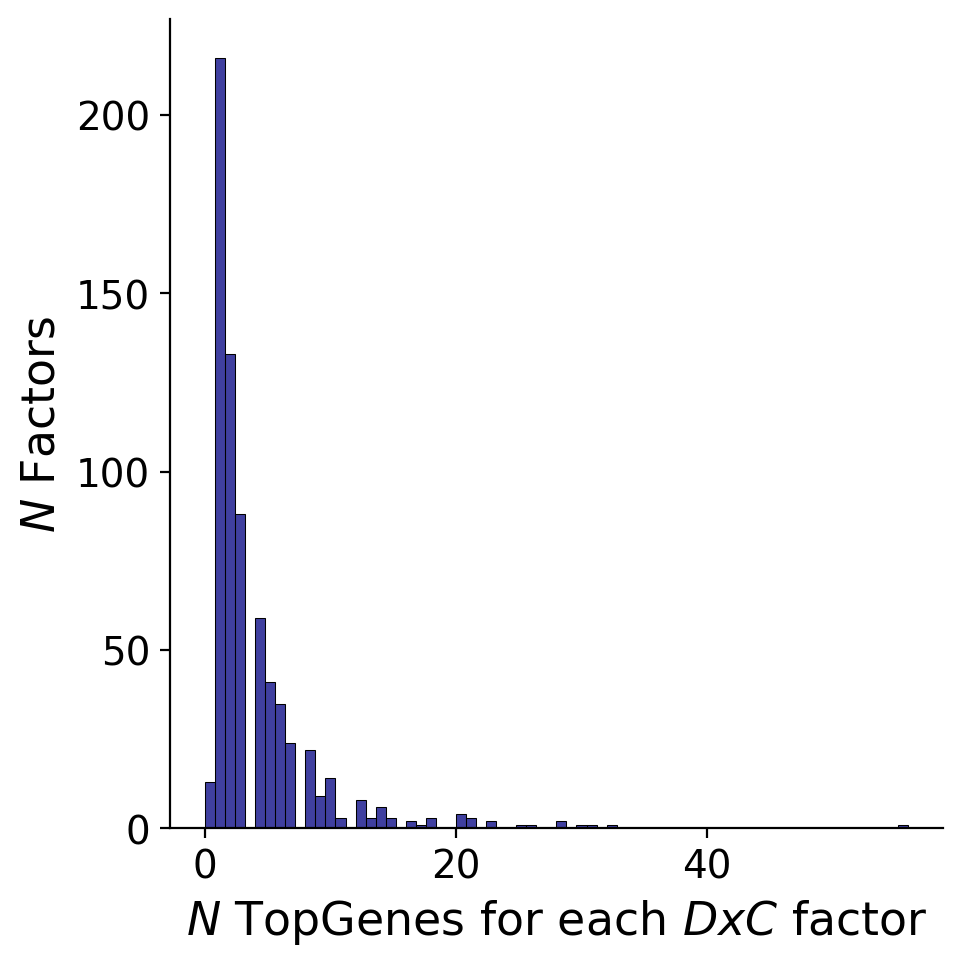

In [134]:
sns.displot(data=factors_topgenes, x="N_genes", color="navy", bins=70)
plt.xlabel("$N$ TopGenes for each $DxC$ factor", fontsize=16.5)
plt.ylabel("$N$ Factors", fontsize=16.5)
plt.savefig(os.path.join(model_results_dir, "Figures", "N-TopGenes-for-each-DxC-factor_only-100-IQR.png"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "N-TopGenes-for-each-DxC-factor_only-100-IQR.eps"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "N-TopGenes-for-each-DxC-factor_only-100-IQR.pdf"), 
            transparent=True, dpi=200, bbox_inches="tight")

In [125]:
factors_topgenes_sign = factors_topgenes.loc[factors_topgenes.Factor.isin(GxC_effects.Factor.str.replace("U", "DxC"))]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


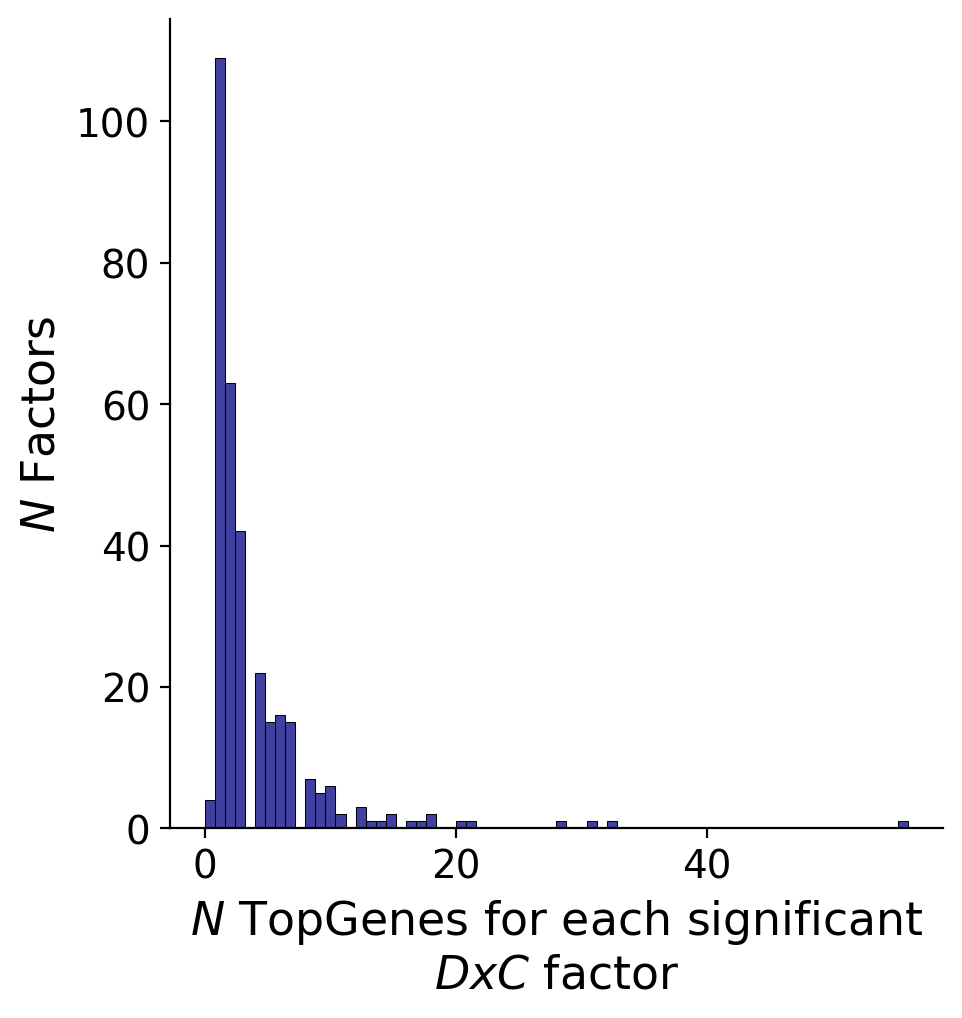

In [135]:
sns.displot(data=factors_topgenes_sign, x="N_genes", color="navy", bins=70)
plt.xlabel(textwrap.fill("$N$ TopGenes for each significant $DxC$ factor", 35), fontsize=16.5)
plt.ylabel("$N$ Factors", fontsize=16.5)
plt.savefig(os.path.join(model_results_dir, "Figures", "N-TopGenes-for-each-significant-DxC-factor_only-100-IQR.png"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "N-TopGenes-for-each-significant-DxC-factor_only-100-IQR.eps"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "N-TopGenes-for-each-significant-DxC-factor_only-100-IQR.pdf"), 
            transparent=True, dpi=200, bbox_inches="tight")

In [14]:
factors_topgenes = factors_topgenes.assign(has_fQTL = factors_topgenes.apply(
    lambda x: x.Factor in GxC_effects.Factor.str.replace("U", "DxC").tolist(), axis=1)
                                          )
factors_topgenes

,Factor,TopGenes,N_genes,has_fQTL
0,DxC_Factor1,FTL; CCL4; RPS16,3,True
1,DxC_Factor2,A1BG; SOX4; ITM2A; CD8B; CD8A; TXNIP; CLEC11A;...,10,False
2,DxC_Factor3,,0,False
3,DxC_Factor4,VMP1; CITED2; TSC22D3; ARRDC3; TNFAIP3; CD69; ...,13,False
4,DxC_Factor5,RPS5; RPS25,2,True
...,...,...,...,...
695,DxC_Factor696,RPS10,1,True
696,DxC_Factor697,MT-CO1; MT-CO3,2,False
697,DxC_Factor698,LGALS2,1,True
698,DxC_Factor699,EEF1D,1,False


In [16]:
factors_topgenes.loc[factors_topgenes.has_fQTL].N_genes.median()

2.0

In [15]:
factors_topgenes.loc[~factors_topgenes.has_fQTL].N_genes.median()

3.0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


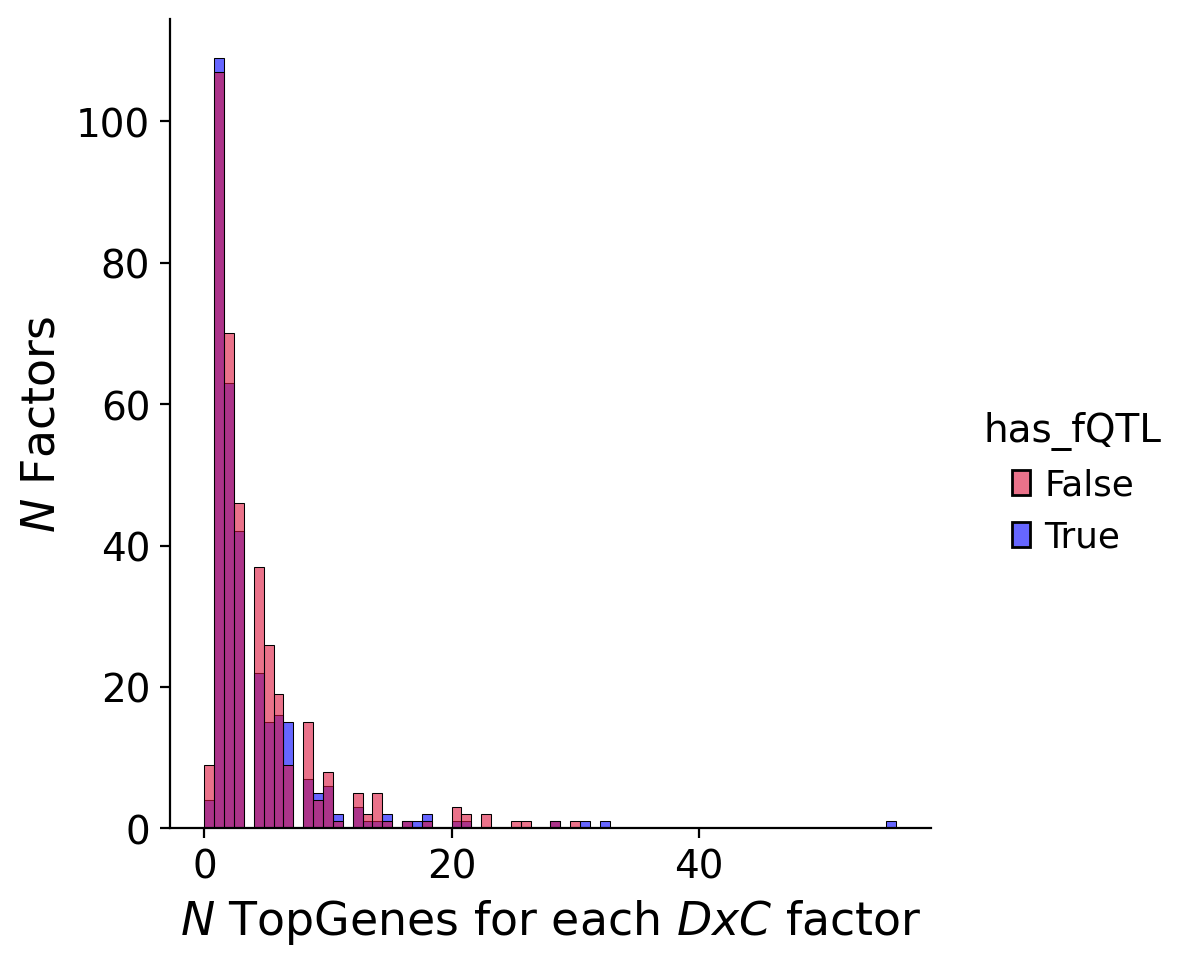

In [151]:
sns.displot(data=factors_topgenes, x="N_genes", hue="has_fQTL", palette=["crimson", "blue"], bins=70, alpha=0.6)
plt.xlabel(textwrap.fill("$N$ TopGenes for each $DxC$ factor", 35), fontsize=16.5)
plt.ylabel("$N$ Factors", fontsize=16.5)
plt.savefig(os.path.join(model_results_dir, "Figures", "N-TopGenes-for-each-DxC-factor_only-100-IQR_has-fQTL.png"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "N-TopGenes-for-each-DxC-factor_only-100-IQR_has-fQTL.eps"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "N-TopGenes-for-each-DxC-factor_only-100-IQR_has-fQTL.pdf"), 
            transparent=True, dpi=200, bbox_inches="tight")

### Assignment matrix

In [17]:
assignment_matrix = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_factor_assignment_matrix.tsv"),
    sep="\t", index_col=0
)
assignment_matrix.columns = assignment_matrix.columns.str.replace("U_", "D_")
assignment_matrix.head()

,D_Factor1,D_Factor2,D_Factor3,D_Factor4,D_Factor5,D_Factor6,D_Factor7,D_Factor8,D_Factor9,D_Factor10,...,D_Factor691,D_Factor692,D_Factor693,D_Factor694,D_Factor695,D_Factor696,D_Factor697,D_Factor698,D_Factor699,D_Factor700
Cell-state_Factor1,8.437773e-07,7.903217e-08,0.000149,2.960464e-08,0.105288,9.999727e-01,5.675518e-07,0.958925,0.000287,0.000158,...,5.023212e-06,4.209568e-06,1.000000e+00,4.168299e-03,9.999992e-01,0.209136,0.078419,6.167789e-07,0.018491,0.140772
Cell-state_Factor2,1.292795e-06,6.067657e-08,0.000136,6.915393e-08,0.105908,1.794856e-02,5.106163e-07,0.115423,0.026317,0.000138,...,1.773568e-07,6.894123e-06,7.097198e-02,2.241115e-07,8.517019e-07,0.047724,0.001983,7.762388e-07,0.000035,0.041986
Cell-state_Factor3,9.953613e-07,6.230532e-08,0.000141,1.447328e-06,0.000004,4.638549e-07,9.892867e-01,0.965989,0.000585,0.000156,...,2.023449e-07,2.216382e-06,5.867200e-05,5.172464e-03,6.707507e-07,0.132809,0.001249,1.094831e-06,0.938939,0.154773
Cell-state_Factor4,6.680752e-07,6.124807e-02,0.000136,3.778137e-08,0.011434,4.063994e-07,9.991040e-01,0.019197,0.008096,0.000136,...,2.121831e-07,3.456871e-07,4.101363e-08,3.866343e-07,6.646220e-07,0.102437,0.012960,7.976132e-07,0.000011,0.032869
Cell-state_Factor5,4.728630e-06,2.615931e-08,0.000146,6.789284e-04,0.123782,2.302163e-07,5.004259e-07,1.000000,0.305943,0.000152,...,8.162028e-08,3.348259e-02,3.075602e-08,2.127417e-07,4.462411e-07,0.080859,0.288426,5.094969e-07,0.029717,0.271452


Text(0.5, 1.0, 'Number of cell-state-factors assigned to each $D$ factor (A >= 0.9)')

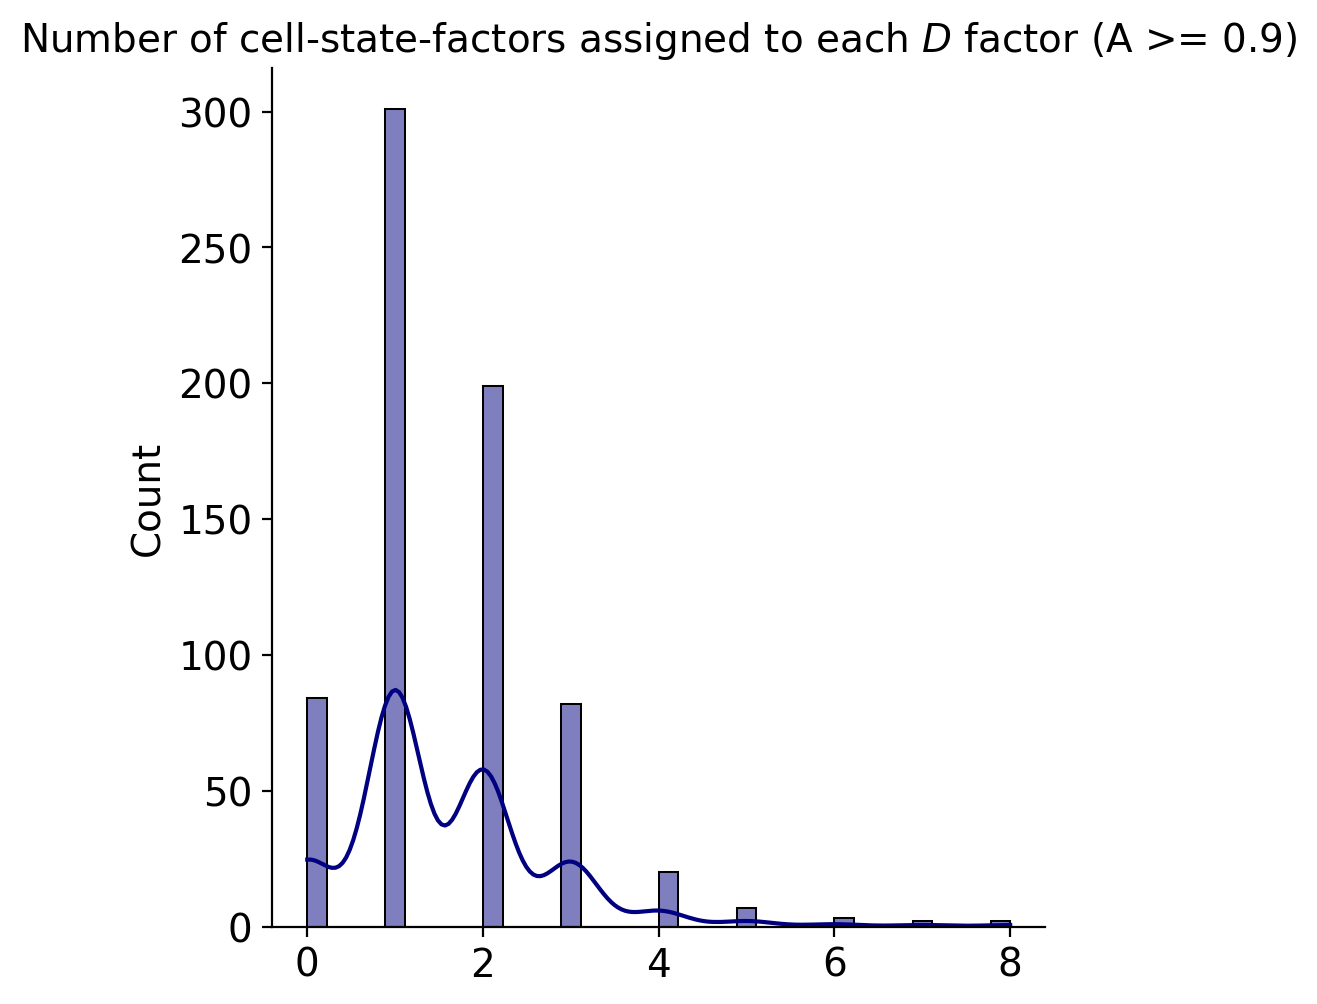

In [18]:
sns.displot(assignment_matrix.T[assignment_matrix.T >= 0.9].notna().sum(axis=1), bins="fd", kde=True, color="navy")
plt.title("Number of cell-state-factors assigned to each $D$ factor (A >= 0.9)")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


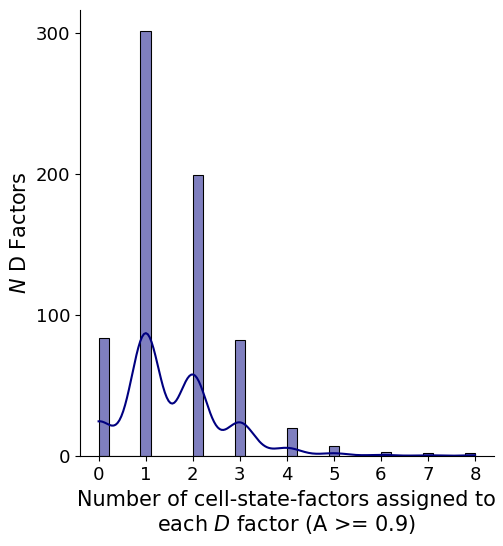

In [42]:
sns.displot(assignment_matrix.T[assignment_matrix.T >= 0.9].notna().sum(axis=1), bins="fd", kde=True, color="navy")
plt.xlabel(textwrap.fill("Number of cell-state-factors assigned to each $D$ factor (A >= 0.9)", 40), fontsize=15)
plt.xticks(np.arange(0, 9, 1), np.arange(0, 9, 1), fontdict={"fontsize":13})
plt.ylabel("$N$ D Factors", fontsize=15)
plt.yticks(np.arange(0, 400, 100), np.arange(0, 400, 100), fontdict={"fontsize":13})
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_N-cell-state-assigned-to-D.png"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_N-cell-state-assigned-to-D.eps"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_N-cell-state-assigned-to-D.pdf"), 
            transparent=True, dpi=200, bbox_inches="tight")

Text(0.5, 1.0, 'Number of cell-state-factors assigned to each significant $D$ factor (A >= 0.9)')

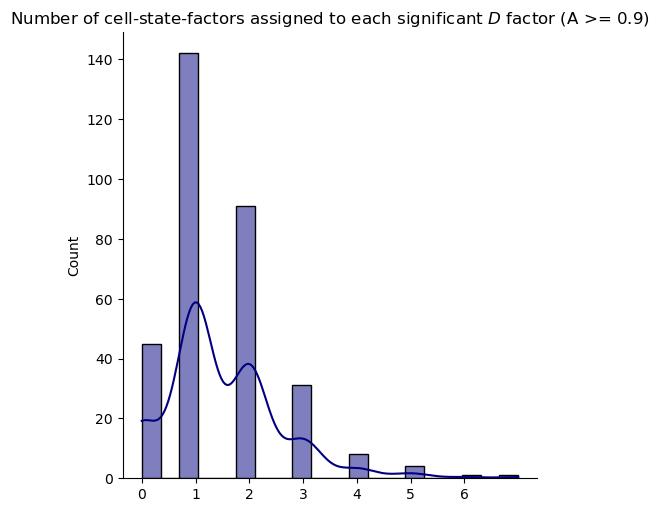

In [43]:
plt.rcParams["figure.figsize"] = (10,10)
sns.displot(assignment_matrix.filter(GxC_effects.Factor.unique()).T[assignment_matrix.filter(GxC_effects.Factor.unique()).T >= 0.9].notna().sum(axis=1),
            bins=20, kde=True, color="navy")
plt.xticks(np.arange(0,7))
plt.title("Number of cell-state-factors assigned to each significant $D$ factor (A >= 0.9)")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


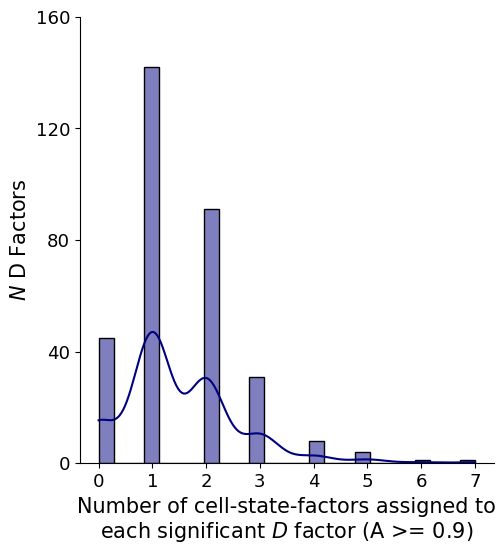

In [48]:
# plt.rcParams["figure.figsize"] = (10,10)
sns.displot(assignment_matrix.filter(GxC_effects.Factor.unique()).T[assignment_matrix.filter(GxC_effects.Factor.unique()).T >= 0.9].notna().sum(axis=1),
            bins="fd", kde=True, color="navy")
plt.xlabel(textwrap.fill("Number of cell-state-factors assigned to each significant $D$ factor (A >= 0.9)", 40), fontsize=15)
plt.xticks(np.arange(0, 8, 1), np.arange(0, 8, 1), fontdict={"fontsize":13})
plt.ylabel("$N$ D Factors", fontsize=15)
plt.yticks(np.arange(0, 180, 40), np.arange(0, 180, 40), fontdict={"fontsize":13})
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_N-cell-state-assigned-to-significant-D.png"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_N-cell-state-assigned-to-significant-D.eps"), 
            transparent=True, dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_N-cell-state-assigned-to-significant-D.pdf"), 
            transparent=True, dpi=200, bbox_inches="tight")